In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from xgboost import XGBClassifier
from hashlib import sha256
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import time
import featuretools as ft
sns.set()

## Data Loading and Cleaning

In [32]:
# Load applications data
train = pd.read_csv('../input/application_train.csv')
test = pd.read_csv('../input/application_test.csv')
#bureau = pd.read_csv('../input/bureau.csv')
#bureau_balance = pd.read_csv('../input/bureau_balance.csv')
#cash_balance = pd.read_csv('../input/POS_CASH_balance.csv')
#card_balance = pd.read_csv('../input/credit_card_balance.csv')
#prev_app = pd.read_csv('../input/previous_application.csv')
#payments = pd.read_csv('../input/installments_payments.csv')

In [ ]:
train.head()

In [ ]:
# Print info about each column in the train dataset
for col in train:
    print(col)
    Nnan = train[col].isnull().sum()
    print('Number empty: ', Nnan)
    print('Percent empty: ', 100*Nnan/train.shape[0])
    print(train[col].describe())
    if train[col].dtype==object:
        print('Categories and Count:')
        print(train[col].value_counts().to_string(header=None))
    print()

In [ ]:
# Print info about each column in the test dataset
for col in test:
    print(col)
    Nnan = test[col].isnull().sum()
    print('Number empty: ', Nnan)
    print('Percent empty: ', 100*Nnan/test.shape[0])
    print(test[col].describe())
    if test[col].dtype==object:
        print('Categories and Count:')
        print(test[col].value_counts().to_string(header=None))
    print()

The column containing the values we are trying to predict, `TARGET`, doesn't contain any missing values.  The value of `TARGET` is $0$ when the loan was repayed sucessfully, and $1$ when there were problems repaying the loan.  Many more loans were succesfully repayed than not, which means that the dataset is imbalanced in terms of our dependent variable, which is something we'll have to watch out for when we build a predictive model later:

In [ ]:
# Show target distribution
train['TARGET'].value_counts()

There's a lot of categorical columns - let's check that, for each column, all the categories we see in the training set we also see in the test set, and vice-versa.

In [ ]:
for col in test:
    if test[col].dtype==object:
        print(col)
        print('Num Unique in Train:', train[col].nunique())
        print('Num Unique in Test: ', test[col].nunique())
        print('Unique in Train:', sorted([str(e) for e in train[col].unique().tolist()]))
        print('Unique in Test: ', sorted([str(e) for e in test[col].unique().tolist()]))
        print()

We'll merge the test and training dataset, and create a column which indicates whether a sample is in the test or train dataset.  That way, we can perform operations (label encoding, one-hot encoding, etc) to all the data together instead of doing it once to the training data and once to the test data.

In [33]:
# Merge test and train into all application data
train['Test'] = False
test['Test'] = True
test['TARGET'] = np.nan
app = train.append(test, ignore_index=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


The gender column contains whether the loan applicant was male or female.  The training datset contains 4 values which weren't empty but were labelled `XNA`.  Normally we would want to create a new column to represent when the gender value is null.  However,  since the test dataset has only `M` and `F` entries, and because there are only 4 entries with a gender of `XNA` in the training set, we'll remove those entries from the training set.

In [34]:
# Remove entries with gender = XNA
app = app[app['CODE_GENDER'] != 'XNA']

The `NAME_INCOME_TYPE` column also contained entries for applicants who were on Maternity leave, but no such applicants were in the test set.  There were only 5 such applicants in the training set, so we'll remove these from the training set.

In [35]:
# Remove entries with income type = maternity leave
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']

Similarly, in the `NAME_FAMILY_STATUS` column, there were 2 entries in the training set with values of `Unknown`, and no entries with that value in the test set.  So, we'll remove those too.

In [36]:
# Remove entries with unknown family status
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

There were some funky values in the `DAYS_EMPLOYED` column:

In [ ]:
app['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.show()

$350,000$ days?  That's like $1,000$ years!  Looks like all the reasonable values represent the number of days between when the applicant was employed and the date of the loan application.  The unreasonable values are all exactly $365,243$, so we'll set those to `NaN`.

In [ ]:
# Show distribution of reasonable values
app.loc[app['DAYS_EMPLOYED']<200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Show all unique outlier values
app.loc[app['DAYS_EMPLOYED']>200000, 'DAYS_EMPLOYED'].unique()

In [37]:
# Set unreasonable values to nan
app.loc[app['DAYS_EMPLOYED']==365243, 'DAYS_EMPLOYED'] = np.nan

The column `WEEKDAY_APPR_PROCESS_START` contains categorical information corresponding to the day of the week.  We could encode these categories as the values 1-7, but this would imply that Sunday and Monday are more similar than, say Tuesday and Sunday.  We could also one-hot encode the column into 7 new columns, but that would create 7 additional dimensions.  Seeing as the week is cyclical, we'll encode this information into two dimensions by encoding them using polar coordinates.  That is, we'll represent the days of the week as a circle.  That way, we can encode the days of the week independently, but only add two dimensions.

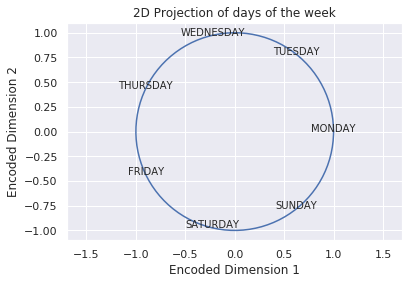

In [38]:
# Create map from categories to polar projection
DOW_map = {
    'MONDAY':    0,
    'TUESDAY':   1,
    'WEDNESDAY': 2,
    'THURSDAY':  3,
    'FRIDAY':    4,
    'SATURDAY':  5,
    'SUNDAY':    6,
}
DOW_map1 = {k: np.cos(2*np.pi*v/7.0) for k, v in DOW_map.items()}
DOW_map2 = {k: np.sin(2*np.pi*v/7.0) for k, v in DOW_map.items()}

# Show encoding of days of week -> circle
days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
tt = np.linspace(0, 2*np.pi, 200)
xx = np.cos(tt)
yy = np.sin(tt)
plt.plot(xx,yy)
plt.gca().axis('equal')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.title('2D Projection of days of the week')
for day in days:
    plt.text(DOW_map1[day], DOW_map2[day], day, ha='center')
plt.show()

In [39]:
# WEEKDAY_APPR_PROCESS_START to polar coords
col = 'WEEKDAY_APPR_PROCESS_START'
app[col+'_1'] = app[col].map(DOW_map1)
app[col+'_2'] = app[col].map(DOW_map2)
app.drop(columns=col, inplace=True)

For the housing-related features (e.g. `LIVINGAPARTMENTS_MODE`, `BASEMENTAREA_AVG`, etc) there are combinations of some PREFIX (e.g. `LIVINGAPARTMENTS`,  `BASEMENTAREA`, etc) and some POSTFIX (e.g. `MODE`, `MEDI`, `AVG`, etc) into a variable `PREFIX_POSTFIX`.  However, if one value for a given PREFIX is empty, the other values for that PREFIX will also be empty.  

For each column which has some empty values, we want to add an indicator column which is 1 if the value in the corresponding column is empty, and 0 otherwise.  However, if we do this with the housing-related features, we'll end up with a bunch of duplicate columns!  This is because the same samples have null values across all the POSTFIX columns for a given PREFIX.   The same problem crops up with the CREDIT_BUREAU-related features. To handle this problem, after creating the null indicator columns, we'll check for duplicate columns and merge them.

So, first we'll add columns to indicate where there are empty values in each other column.

In [40]:
# Add indicator columns for empty values
for col in app:
    if col!='Test' and col!='TARGET':
        app_null = app[col].isnull()
        if app_null.sum()>0:
            app[col+'_ISNULL'] = app_null

Then we can label encode categorical features with only 2 possible values (that is, turn the labels into either 0 or 1).

In [41]:
# Label encoder
le = LabelEncoder()

# Label encode binary fearures in training set
for col in app: 
    if col!='Test' and col!='TARGET' and app[col].dtype==object and app[col].nunique()==2:
        if col+'_ISNULL' in app.columns: #missing values here?
            app.loc[app[col+'_ISNULL'], col] = 'NaN'
        app[col] = le.fit_transform(app[col])
        if col+'_ISNULL' in app.columns: #re-remove missing vals
            app.loc[app[col+'_ISNULL'], col] = np.nan

Then we'll one-hot encode the categorical features which have more than 2 possible values.

In [42]:
# Get categorical features to encode
cat_features = []
for col in app: 
    if col!='Test' and col!='TARGET' and app[col].dtype==object and app[col].nunique()>2:
        cat_features.append(col)

# One-hot encode categorical features in train set
app = pd.get_dummies(app, columns=cat_features)

And finally we'll remove duplicate columns.  We'll hash the columns and check if the hashes match before checking if all the values actually match, because it's a lot faster than comparing $O(N^2)$ columns elementwise.

In [43]:
# Hash columns
hashes = dict()
for col in app:
    hashes[col] = sha256(app[col].values).hexdigest()
    
# Get list of duplicate column lists
Ncol = app.shape[1] #number of columns
dup_list = []
dup_labels = -np.ones(Ncol)
for i1 in range(Ncol):
    if dup_labels[i1]<0: #if not already merged,
        col1 = app.columns[i1]
        t_dup = [] #list of duplicates matching col1
        for i2 in range(i1+1, Ncol):
            col2 = app.columns[i2]
            if ( dup_labels[i2]<0 #not already merged
                 and hashes[col1]==hashes[col2] #hashes match
                 and app[col1].equals(app[col2])): #cols are equal
                #then this is actually a duplicate
                t_dup.append(col2)
                dup_labels[i2] = i1
        if len(t_dup)>0: #duplicates of col1 were found!
            t_dup.append(col1)
            dup_list.append(t_dup)
        
# Merge duplicate columns
for iM in range(len(dup_list)):
    new_name = 'Merged'+str(iM)
    app[new_name] = app[dup_list[iM][0]].copy()
    app.drop(columns=dup_list[iM], inplace=True)
    print('Merged', dup_list[iM], 'into', new_name)

Merged ['AMT_REQ_CREDIT_BUREAU_HOUR_ISNULL', 'AMT_REQ_CREDIT_BUREAU_MON_ISNULL', 'AMT_REQ_CREDIT_BUREAU_QRT_ISNULL', 'AMT_REQ_CREDIT_BUREAU_WEEK_ISNULL', 'AMT_REQ_CREDIT_BUREAU_YEAR_ISNULL', 'AMT_REQ_CREDIT_BUREAU_DAY_ISNULL'] into Merged0
Merged ['APARTMENTS_MEDI_ISNULL', 'APARTMENTS_MODE_ISNULL', 'APARTMENTS_AVG_ISNULL'] into Merged1
Merged ['BASEMENTAREA_MEDI_ISNULL', 'BASEMENTAREA_MODE_ISNULL', 'BASEMENTAREA_AVG_ISNULL'] into Merged2
Merged ['COMMONAREA_MEDI_ISNULL', 'COMMONAREA_MODE_ISNULL', 'COMMONAREA_AVG_ISNULL'] into Merged3
Merged ['DEF_60_CNT_SOCIAL_CIRCLE_ISNULL', 'OBS_30_CNT_SOCIAL_CIRCLE_ISNULL', 'OBS_60_CNT_SOCIAL_CIRCLE_ISNULL', 'DEF_30_CNT_SOCIAL_CIRCLE_ISNULL'] into Merged4
Merged ['ELEVATORS_MEDI_ISNULL', 'ELEVATORS_MODE_ISNULL', 'ELEVATORS_AVG_ISNULL'] into Merged5
Merged ['ENTRANCES_MEDI_ISNULL', 'ENTRANCES_MODE_ISNULL', 'ENTRANCES_AVG_ISNULL'] into Merged6
Merged ['FLOORSMAX_MEDI_ISNULL', 'FLOORSMAX_MODE_ISNULL', 'FLOORSMAX_AVG_ISNULL'] into Merged7
Merged ['FLOOR

## Deep Feature Synthesis



In [ ]:
# Create entities
# Each entry is "Name": (df, "id_col_name")
entities = { #use id_col_name not in df for new index, w/ None uses 1st col
    'app' : (app, 'SK_ID_CURR'),
    'bureau' : (bureau, 'SK_ID_BUREAU'),
    'bureau_balance' : (bureau, 'New'),
    'cash_balance' : (cash_balance, 'New'),
    'card_balance' : (card_balance, 'New'),
    'prev_app' : (prev_app, 'SK_ID_PREV'),
    'payments' : (payments, 'New') 
}

NOTE: dunno if the above will work - some dfs (bureau_balance, cash_balance, card_balance, and payments) don't have indexes already.  Will it work as is?  Might have to set the id_col_name to None?  Or might have to do it the way as in the kaggle kernel where you call entity_from_dataframe with make_index=True

In [ ]:
# Define relationships between dataframes
# Each entry is (parent_entity, parent_variable, child_entity, child_variable)
relationships = [
    ('app', 'SK_ID_CURR', 'bureau', 'SK_ID_CURR'),
    ('bureau', 'SK_ID_BUREAU', 'bureau_balance', 'SK_ID_BUREAU'),
    ('app', 'SK_ID_CURR', 'prev_app', 'SK_ID_CURR'),
    ('app', 'SK_ID_CURR', 'cash_balance', 'SK_ID_CURR'),
    ('app', 'SK_ID_CURR', 'payments', 'SK_ID_CURR'),
    ('app', 'SK_ID_CURR', 'card_balance', 'SK_ID_CURR')
]

NOTE: cash_balance, payments, and card_balance could probs be linked to prev_app via SK_ID_PREV, instead of directly thru SK_ID_CURR, because they correspond to stuff from previous loans...

In [ ]:
"""
# Define which primitives to use
#agg_primitives =  ['mean', 'std', 'min', 'max', 'count', 'percent_true', 'num_unique']
#agg_primitives =  ['mean', 'std', 'count'] #also fails
agg_primitives =  ['count']
trans_primitives = [] #don't use any for now...

# Run deep feature synthesis
t0 = time.time()
dfs_feat, dfs_defs = ft.dfs(entities=entities,
                            relationships=relationships,
                            target_entity='app',
                            trans_primitives = trans_primitives,
                            agg_primitives=agg_primitives, 
                            max_depth=1)
print('DFS took %0.3g sec' % (time.time()-t0))
"""

NOTE: this is just to see if DFS will work in a kaggle kernel. You'll have to then insert the dfs_feat matrix (deep feature synthesized feature matrix) back into the app dataframe (or replace the app dataframe with it, really)

## Prediction

In [44]:
# Split data back into test + train
train = app.loc[~app['Test'], :]
test = app.loc[app['Test'], :]

# Make SK_ID_CURR the index
train.set_index('SK_ID_CURR', inplace=True)
test.set_index('SK_ID_CURR', inplace=True)

# Ensure all data is stored as floats
train = train.astype(np.float32)
test = test.astype(np.float32)

# Target labels
train_y = train['TARGET']

# Remove test/train indicator column and target column
train.drop(columns=['Test', 'TARGET'], inplace=True)
test.drop(columns=['Test', 'TARGET'], inplace=True)

In [ ]:
# Classification pipeline
xgb_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', XGBClassifier())
])

In [ ]:
"""
# Cross-validated AUROC
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True)
scores = cross_val_score(xgb_pipeline, train, train_y, 
                         cv=3, scoring=auroc_scorer)
print('Mean AUROC:', scores.mean())

# Fit to training data
xgb_fit = xgb_pipeline.fit(train, train_y)

# Predict default probabilities of test data
test_pred = xgb_fit.predict_proba(test)

# Save predictions to file
df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test.index
df_out['TARGET'] = test_pred[:,1]
df_out.to_csv('xgboost_baseline.csv', index=False)
"""

## Calibration

One problem with the tree-based model is that the predicted probabilities tend to be overconfident.  That is, when the actual probability of class=1 is closer to 0.5, the model predicts probabilities closer to 0 or 1 than 0.5:

In [15]:
"""
# Predict probabilities for training data
train_pred = cross_val_predict(xgb_pipeline, 
                               train, 
                               y=train_y,
                               method='predict_proba')
train_pred = train_pred[:,1] #only want p(default)

# Show calibration curve
fraction_of_positives, mean_predicted_value = \
    calibration_curve(train_y, train_pred, n_bins=10)
plt.figure()
plt.plot([0, 1], [0, 1], 'k:', 
         label='Perfectly Calibrated')
plt.plot(mean_predicted_value, 
         fraction_of_positives, 's-',
         label='XGBoost Predictions')
plt.legend()
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration curve for baseline XGBoost model')
plt.show()
"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-15-ca07da915461>, line 21)

The model is pretty well calibrated as is, exept for at higher predicted probabilities.  We can "calibrate" our model by adjusting predicted probabilities to more accurately reflect the probability of loan default.  

There are two commonly-used methods for model calibration:

1. Sigmoid calibration (aka Platt's scaling, which transforms the model's predictions using a sigmoid so they more accurately reflect the actual probabilities)
1. Isotonic calibration (which calibrates the model's predictions using a method based on isotonic regression)

We'll try both methods, and see if either betters the calibration of our model.

In [45]:
# Classification pipeline w/ isotonic calibration
calib_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', CalibratedClassifierCV(
                        base_estimator=XGBClassifier(),
                        method='isotonic'))
])

# Classification pipeline w/ sigmoid calibration
sig_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', CalibratedClassifierCV(
                        base_estimator=XGBClassifier(),
                        method='sigmoid'))
])

In [ ]:
"""
# Predict probabilities w/ isotonic calibration
calib_pred = cross_val_predict(calib_pipeline, 
                               train, 
                               y=train_y,
                               method='predict_proba')
calib_pred = calib_pred[:,1] #only want p(default)

# Predict probabilities w/ sigmoid calibration
sig_pred = cross_val_predict(sig_pipeline, 
                             train, 
                             y=train_y,
                             method='predict_proba')
sig_pred = sig_pred[:,1] #only want p(default)

# Show calibration curve
fop_calib, mpv_calib = \
    calibration_curve(train_y, calib_pred, n_bins=10)
fop_sig, mpv_sig = \
    calibration_curve(train_y, sig_pred, n_bins=10)
plt.figure()
plt.plot([0, 1], [0, 1], 'k:', 
         label='Perfectly Calibrated')
plt.plot(mean_predicted_value, 
         fraction_of_positives, 's-',
         label='XGBoost Predictions')
plt.plot(mpv_calib, fop_calib, 's-',
         label='Calibrated Predictions - isotonic')
plt.plot(mpv_sig, fop_sig, 's-',
         label='Calibrated Predictions - sigmoid')
plt.legend()
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration curve for Calibrated XGBoost model')
plt.show()
"""

Sigmoid calibration didn't appear to work very well in this case...  Isotonic calibration didn't work perfectly either, however it did appear to improve the model's discrimination a small bit (the model without calibration has slightly poorer discrimination in that it is more likely to predict probabilities which are close to 0.5).  Isotonic calibration is usually only recommended if one has $>>1000$ datapoints, which we do (the training set contains around 300,000 datapoins), so we'll go ahead and use isotonic calibration.  Now we can output our predictions after calibrating.

In [ ]:
"""
# Cross-validated AUROC
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True)
scores = cross_val_score(calib_pipeline, train, train_y, 
                         cv=3, scoring=auroc_scorer)
print('Mean AUROC with calibration:', scores.mean())

# Fit to training data
calib_fit = calib_pipeline.fit(train, train_y)

# Predict default probabilities of test data
test_pred = calib_fit.predict_proba(test)

# Save predictions to file
df_out = pd.DataFrame()
df_out['SK_ID_CURR'] = test.index
df_out['TARGET'] = test_pred[:,1]
df_out.to_csv('xgboost_calibrated.csv', index=False)
"""

## Class Imbalance

The target class is very imbalanced: many more people successfully repaid their loans than had trouble repaying.

In [ ]:
# Show distribution of target variable
sns.countplot(x='TARGET', data=app)
plt.title('Number of applicants who had trouble repaying')
plt.show()

We'll use the [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html) package to re-sample our dataset such that the classes are balanced.  There are several different common methods we could use for re-sampling: 

1. Random over-sampling (randomly repeat minority class examples in the training data)
1. Random under-sampling (randomly drop majority class examples from the training data)
1. Synthetic minority oversampling technique (SMOTE, generate additional synthetic training examples which are similar to the minority class)

We'll try all three techniques, and see if any of the techniques give better predictive performance in terms of the AUROC.

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with in

Oversampling AUROC: 0.7266395314275723


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with in

Undersampling AUROC: 0.7322795349243816


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with in

SMOTE AUROC: 0.6766241804353528


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with in

No resampling AUROC: 0.744856158755136


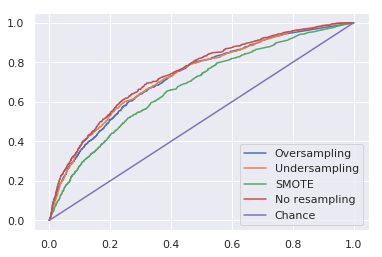

In [56]:
# Sampler that doesn't re-sample!
class DummySampler(object):
    def sample(self, X, y):
        return X, y
    def fit(self, X, y):
        return self
    def fit_sample(self, X, y):
        return self.sample(X, y)
    
# List of samplers to test
samplers = [
    ['Oversampling', RandomOverSampler()], 
    ['Undersampling', RandomUnderSampler()], 
    ['SMOTE', SMOTE()],
    ['No resampling', DummySampler()]
]

# Preprocessing pipeline
pre_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])

# Classifier
classifier = CalibratedClassifierCV(
                        base_estimator=XGBClassifier(),
                        method='isotonic')

# Compute AUROC and plot ROC for each type of sampler
plt.figure()
auroc_scorer = make_scorer(roc_auc_score, needs_proba=True)
cv = StratifiedKFold(n_splits=3)
for name, sampler in samplers:
    
    # Make the sampling and classification pipeline
    pipeline = make_pipeline(sampler, calib_pipeline)

    # Cross-validated predictions on training set
    probas = np.zeros(train.shape[0]) # to store predicted probabilities
    for tr, te in cv.split(train, train_y):
        test_pre = pre_pipeline.fit_transform(train.iloc[te])  #preprocess test fold
        train_pre = pre_pipeline.fit_transform(train.iloc[tr]) #preprocess training fold
        train_s, train_y_s = sampler.fit_sample(train_pre, train_y.iloc[tr]) #resample train fold
        probas_ = classifier.fit(train_s, train_y_s).predict_proba(test_pre) #predict test fold
        probas[te] = probas_[:,1]
    
    # Print AUROC value
    print(name, 'AUROC:', roc_auc_score(train_y, probas))
    
    # Plot ROC curve for this sampler
    fpr, tpr, threshs = roc_curve(train_y, probas)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], label='Chance')
plt.legend()
plt.show()

Notes:

Feature selection with Mutual information?  Featuretools?

interaction terms and keep ones w/ high MI?  Poly features shouldn't be needed for tree method... but would want em if doing logistic reg.

Gonna have to do oversampling/undersampling to account for that class imbalance

XGboost

CALIBRATION.  Tried sigmoid calibration but was even worse than isotonic.

Bayesian paramater optimization?

Talk about monitoring and correcting for systematic racism, etc